In [1]:
import time
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve,roc_auc_score

from tensorflow import keras
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import pickle

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def save_pickle(variable,filename,folder):
    pickle_out=open(str(folder)+"/"+str(filename) + ".pickle","wb")
    pickle.dump(variable,pickle_out)
    pickle_out.close()
    
def load_pickle(filename,folder):
    return pickle.load(open(str(folder)+"/"+str(filename) + ".pickle","rb"))

In [3]:
def network_analysis(network_model,model_fit,X_test,y_test):
    test_loss, test_acc = network_model.evaluate(X_test, y_test)
    y_preds=pd.DataFrame(network_model.predict(X_test))
    fpr, tpr, _=roc_curve(y_test,y_preds)
    far,frr=fpr,1-tpr
    err=max(np.argwhere(np.diff(np.sign(far - frr))).flatten())
    x_points=np.linspace(0,1,num=len(far))
    
    print('Test accuracy:' + str(round(test_acc*100,2))+"%")
    print('Model fit and testing time:' + str(round(end - start,2))+"s")
    
    figure, axis = plt.subplots(2,2,figsize=(15,15))
    
    axis[0,0].plot(model_fit.history['loss'],'k',linewidth=3.0)
    axis[0,0].plot(model_fit.history['val_loss'],'b',linewidth=3.0)
    axis[0,0].legend(['Training loss', 'Validation Loss'],fontsize=12)
    axis[0,0].set_xlabel('Epochs ',fontsize=16)
    axis[0,0].set_ylabel('Loss',fontsize=16)
    axis[0,0].set_title('Loss Curves',fontsize=16)
    
    axis[0,1].plot(model_fit.history['accuracy'],'k',linewidth=3.0)
    axis[0,1].plot(model_fit.history['val_accuracy'],'b',linewidth=3.0)
    axis[0,1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    axis[0,1].set_xlabel('Epochs ',fontsize=16)
    axis[0,1].set_ylabel('Accuracy',fontsize=16)
    axis[0,1].set_title('Accuracy Curves',fontsize=16)
    
    axis[1,0].set_title("ROC Curve",fontsize=16)
    axis[1,0].plot(fpr,tpr,'b')
    axis[1,0].set_ylabel('TPR: True Positive Rate')
    axis[1,0].set_ylim(0, 1)
    axis[1,0].set_xlabel('FPR: False Positive Rate')
    axis[1,0].set_xlim(0, 1)
    
    axis[1,1].set_title("FRR FAR Curve",fontsize=16)
    axis[1,1].plot(x_points,far,'k',label ='FAR')
    axis[1,1].plot(x_points,frr,'b',label ='FRR')
    axis[1,1].scatter(x_points[err], far[err],s=100)
    axis[1,1].text(x_points[err]+0.05,far[err],"Equal Error Rate ~" +
               str(round(far[err],4)),fontsize = 10)
    axis[1,1].legend(loc ="center left")
    axis[1,1].set_ylabel('Error Rate')
    axis[1,1].set_ylim(0, 1)
    axis[1,1].axes.get_xaxis().set_visible(False)
    

    plt.show()

In [4]:
def build_cnn_model(hp):
    CNN_model = Sequential()
    
    CNN_model.add(Conv2D(hp.Int("input_layer",32,256,32),
                         3,padding='same', activation="relu",
                         input_shape=X[1,:].shape, name="Input_Layer"))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(BatchNormalization())
    CNN_model.add(Dropout(0.8))
    
    for i in range(3):
        CNN_model.add(Conv2D(hp.Int(f'conv_{i}_layers',32,512,32),3,
                             padding='same', activation="relu",name=f"Convolutional_Layer_{i}"))
        CNN_model.add(BatchNormalization())
        CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
        
    CNN_model.add(Flatten())
    CNN_model.add(Dense(32,activation="relu",name='FullyConnected_Layer'))
    CNN_model.add(Dropout(0.6))
    
    CNN_model.add(Dense(1, activation='sigmoid', name='Output_Layer'))
    
    opt=Adam(learning_rate=1e-4)
    CNN_model.compile(optimizer=opt, 
                      loss="binary_crossentropy",
                      metrics=['accuracy'])
    
    return CNN_model

In [5]:
def best_network_hyperparameter(model_builder,trials,filename):
    tuner = RandomSearch(
        model_builder,
        objective='val_accuracy',
        max_trials=trials,
        executions_per_trial=1,
        directory='project',
        project_name=filename)
    criterion=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    tuner_result = tuner.search(X_train, y_train,epochs=20,batch_size=64,validation_split=0.1,callbacks=[criterion])
    
    return tuner.get_best_hyperparameters()[0]

In [6]:
def network_fit(network_model,bsize,epoch,X_train,y_train):
    criterion=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=70)
    model_fit = network_model.fit(X_train, y_train, batch_size=bsize, epochs=epoch, verbose=2,
                      validation_split=0.1,callbacks=[criterion])
    return model_fit

In [7]:
#loading data
random_state=42
X_data_file,y_data_file,data_folder="X","y","data"
X_data=load_pickle(X_data_file,data_folder)
y_data=load_pickle(y_data_file,data_folder)

In [8]:
X=np.asarray(X_data).astype('float64')/255
y=np.array(y_data)
Xnn=np.asarray(X_data).astype('float64')/255
ynn=np.array(y_data)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=42)

In [10]:
filename,folder="cnn_hyperparameter","project"
#cnn_hyperparameter=best_network_hyperparameter(build_cnn_model,100,filename)
#save_pickle(cnn_hyperparameter,filename,folder)

In [11]:
cnn_hyperparameters=load_pickle(filename,folder)
print(cnn_hyperparameters.values)

{'input_layer': 224, 'conv_0_layers': 48, 'conv_1_layers': 80, 'conv_2_layers': 80}


In [12]:
CNN_model=build_cnn_model(cnn_hyperparameters)
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (Conv2D)        (None, 96, 96, 224)       2240      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 224)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 224)      896       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 48, 48, 224)       0         
                                                                 
 Convolutional_Layer_0 (Conv  (None, 48, 48, 48)       96816     
 2D)                                                             
                                                        

In [13]:
start = time.time()
CNN_fit=network_fit(CNN_model,16,120,X_train,y_train)
end = time.time()

Epoch 1/120
104/104 - 12s - loss: 0.9893 - accuracy: 0.4973 - val_loss: 0.7423 - val_accuracy: 0.4649 - 12s/epoch - 113ms/step
Epoch 2/120
104/104 - 3s - loss: 0.7144 - accuracy: 0.5250 - val_loss: 0.7378 - val_accuracy: 0.4649 - 3s/epoch - 26ms/step
Epoch 3/120
104/104 - 3s - loss: 0.6898 - accuracy: 0.5352 - val_loss: 0.7016 - val_accuracy: 0.5081 - 3s/epoch - 25ms/step
Epoch 4/120
104/104 - 3s - loss: 0.6814 - accuracy: 0.5562 - val_loss: 0.6930 - val_accuracy: 0.5676 - 3s/epoch - 24ms/step
Epoch 5/120
104/104 - 3s - loss: 0.6795 - accuracy: 0.5646 - val_loss: 0.6956 - val_accuracy: 0.5676 - 3s/epoch - 24ms/step
Epoch 6/120
104/104 - 3s - loss: 0.6755 - accuracy: 0.5574 - val_loss: 0.7110 - val_accuracy: 0.5730 - 3s/epoch - 25ms/step
Epoch 7/120
104/104 - 3s - loss: 0.6674 - accuracy: 0.5947 - val_loss: 0.7126 - val_accuracy: 0.5622 - 3s/epoch - 25ms/step
Epoch 8/120
104/104 - 3s - loss: 0.6525 - accuracy: 0.6079 - val_loss: 0.6633 - val_accuracy: 0.6270 - 3s/epoch - 25ms/step
Epoch

Epoch 67/120
104/104 - 3s - loss: 0.0872 - accuracy: 0.9609 - val_loss: 0.9294 - val_accuracy: 0.6973 - 3s/epoch - 25ms/step
Epoch 68/120
104/104 - 3s - loss: 0.0943 - accuracy: 0.9591 - val_loss: 0.9902 - val_accuracy: 0.6811 - 3s/epoch - 25ms/step
Epoch 69/120
104/104 - 3s - loss: 0.0788 - accuracy: 0.9693 - val_loss: 0.8229 - val_accuracy: 0.7351 - 3s/epoch - 25ms/step
Epoch 70/120
104/104 - 3s - loss: 0.0878 - accuracy: 0.9657 - val_loss: 0.8715 - val_accuracy: 0.7027 - 3s/epoch - 25ms/step
Epoch 71/120
104/104 - 3s - loss: 0.0822 - accuracy: 0.9663 - val_loss: 0.9827 - val_accuracy: 0.7081 - 3s/epoch - 25ms/step
Epoch 72/120
104/104 - 3s - loss: 0.0756 - accuracy: 0.9693 - val_loss: 0.6605 - val_accuracy: 0.7892 - 3s/epoch - 25ms/step
Epoch 73/120
104/104 - 3s - loss: 0.0858 - accuracy: 0.9585 - val_loss: 0.4945 - val_accuracy: 0.8108 - 3s/epoch - 25ms/step
Epoch 74/120
104/104 - 3s - loss: 0.0735 - accuracy: 0.9717 - val_loss: 0.6210 - val_accuracy: 0.7784 - 3s/epoch - 25ms/step


25/25 [==============================] - 0s 10ms/step
Test accuracy:79.42%
Model fit and testing time:318.7s


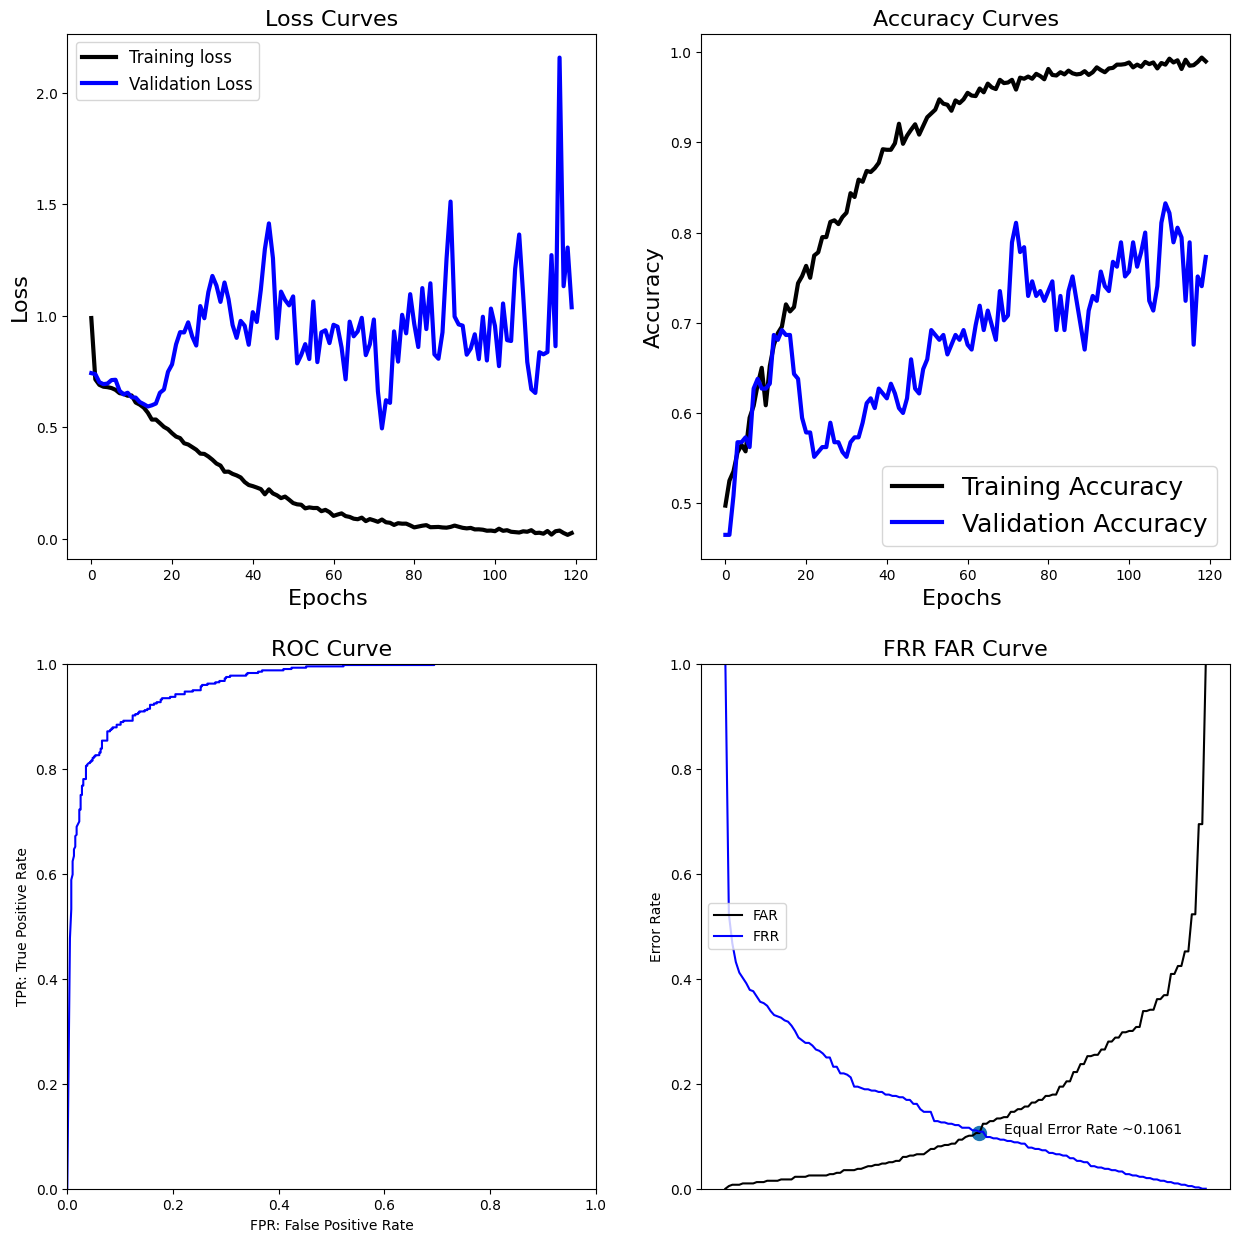

In [14]:
network_analysis(CNN_model,CNN_fit,X_test,y_test)